In [28]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import numpy as np
import cv2
import os
from skimage.morphology import convex_hull_image, binary_closing, square, dilation
from scipy import ndimage

In [3]:
#  load all images from a directory
def load_images_from_folder(folder):
    images = []
    filenames = []
    for filename in tqdm(os.listdir(folder)):
        try:
            img = Image.open(os.path.join(folder,filename))
            if img is not None:
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                images.append(img)
                filenames.append(filename)
        except Exception as e:
            print(e)
    return images, filenames

In [4]:
# load all jsons from a directory
def load_jsons_from_folder(folder):
    jsons = []
    filenames = []
    for filename in tqdm(os.listdir(folder)):
        try:
            json = pd.read_json(os.path.join(folder,filename))
            if json is not None:
                jsons.append(json)
                filenames.append(filename)
        except Exception as e:
            print(e)
    return jsons, filenames

In [5]:
human_parsing = load_images_from_folder('Task/dataset/human_parsing')
image = load_images_from_folder('Task/dataset/image')
pose_img = load_images_from_folder('Task/dataset/pose_img')
pose_json = load_jsons_from_folder('Task/dataset/pose_json')

 93%|█████████▎| 653/705 [00:00<00:00, 2437.86it/s]

cannot identify image file 'Task/dataset/image\\.DS_Store'


100%|██████████| 704/704 [00:01<00:00, 368.48it/s]


In [6]:
df = pd.DataFrame()
df['human_parsing'] = human_parsing[0]
df['image'] = image[0]
df['pose_img'] = pose_img[0]
df['pose_json'] = pose_json[0]

In [7]:
# assert all(human_parsing[1] == image[1] == pose_img[1])
df_names = pd.DataFrame()
df_names['human_parsing'] = human_parsing[1]
df_names['image'] = image[1]
df_names['pose_img'] = pose_img[1]
df_names['pose_json'] = pose_json[1]

In [8]:
def show_images_df(df, index):
    fig, axs = plt.subplots(1, 3, figsize=(20, 20))
    axs[0].imshow(df['human_parsing'][index])
    axs[1].imshow(df['image'][index])
    axs[2].imshow(df['pose_img'][index])

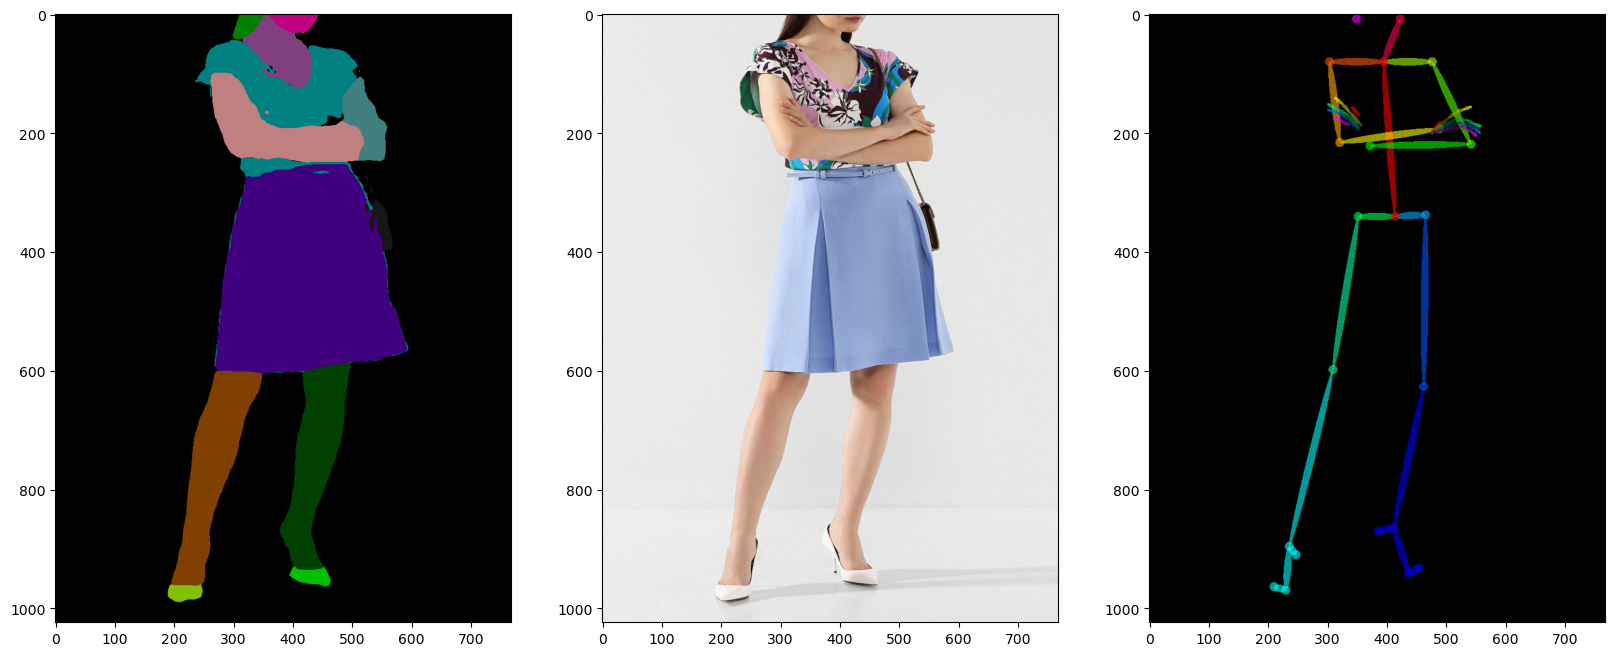

In [9]:
show_images_df(df, 0)

In [10]:
df['pose_keypoints'] = df.pose_json.apply(lambda x: x.people[0].get('pose_keypoints_2d'))

In [11]:
# draw circles for each dot in poses and add annotation with number of big size
# def draw_pose(img, poses):
#     draw = ImageDraw.Draw(img)
#     for i in range(0, len(poses), 3):
#         draw.ellipse((poses[i]-5, poses[i+1]-5, poses[i]+5, poses[i+1]+5), fill=(255, 0, 0, 255))
#         draw.text((poses[i], poses[i+1]), str(i//3), fill=(255, 0, 0, 0), font= ImageFont.truetype("arial.ttf", 30))
#     return img
# draw_pose(df.image[0], df.pose_keypoints[0])

In [12]:
short_colors = {(64, 0, 128), (192, 0, 0)}
legs_colors = {(128,64,0), (0,64,0)}

shirt_colors = {(128,0,128), (128,128,128), (128,64,128)}
hands_colors = {(192,128,128),(64,128,128)}

skirt_colors = short_colors.union(legs_colors)
body_colors = shirt_colors.union(hands_colors)

In [13]:
def get_color_mask(img, colors):
    img = np.array(img)
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    for color in colors:
        mask += np.all(img == color, axis=-1).astype(np.uint8)
    return mask

In [14]:
mask_legs_and_shorts = [get_color_mask(a, skirt_colors) for a in tqdm(human_parsing[0])]

100%|██████████| 704/704 [00:52<00:00, 13.46it/s]


In [15]:
mask_upper_body = [get_color_mask(a, body_colors) for a in tqdm(human_parsing[0])]

100%|██████████| 704/704 [01:04<00:00, 10.86it/s]


In [16]:
# mask_shirts = [get_color_mask(a, shirt_colors) for a in tqdm(human_parsing[0])]

In [17]:
# imshow(mask_shirts[235])

In [18]:
tqdm._instances.clear()

In [19]:
mask_skirts_clean = [np.logical_and(a, np.logical_not(b)) for a, b in tqdm(zip(mask_legs_and_shorts, mask_upper_body))]

704it [00:00, 894.86it/s]


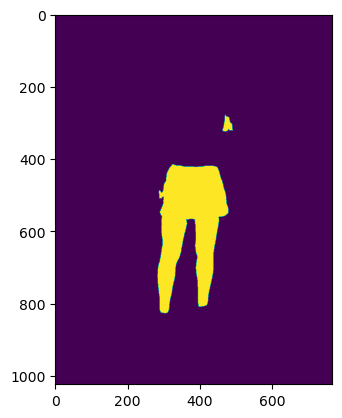

In [20]:
imshow(mask_skirts_clean[235])

In [29]:
def clean_outliers(mask):
    labels, num_labels = ndimage.label(mask)
    component_sizes = ndimage.sum(mask, labels, range(num_labels + 1))
    mask_largest_component = (labels == component_sizes.argmax())
    return mask_largest_component

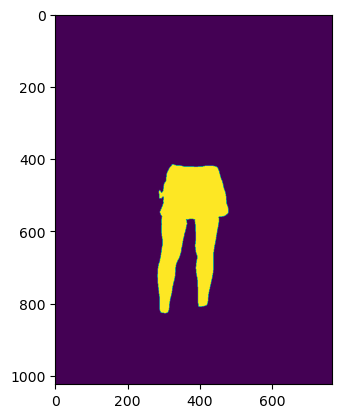

In [31]:
mask = clean_outliers(mask_skirts_clean[235])
imshow(mask)

In [33]:
tqdm._instances.clear()
mask_skirts_clean_no_outliers = [clean_outliers(a) for a in tqdm(mask_skirts_clean)]

100%|██████████| 704/704 [00:13<00:00, 50.48it/s]


In [34]:
tqdm._instances.clear()
mask_skirts_clean_convex = [convex_hull_image(a) for a in tqdm(mask_skirts_clean_no_outliers)]

100%|██████████| 704/704 [01:24<00:00,  8.36it/s]


In [38]:
# delete higher body from mask_skirts_clean_convex
mask_skirts_final = [np.logical_and(a, np.logical_not(b)) for a, b in tqdm(zip(mask_skirts_clean_convex, mask_upper_body))]

704it [00:00, 764.93it/s]


In [39]:
# apply skirt mask as gray color
def apply_mask(img, mask):
    img = np.array(img)
    img[mask] = (128, 128, 128)
    return Image.fromarray(img)

In [40]:
processed_images = [apply_mask(a, b) for a, b in tqdm(zip(df.image, mask_skirts_final))]

704it [00:08, 84.17it/s] 


In [41]:
# save processed_images to /preprocessed
for i, img in tqdm(enumerate(processed_images)):
    img.save('C:/code/python/test_task_big/preprocessed_2/' + df_names.image[i])

704it [00:08, 85.93it/s] 


In [ ]:
# todo:
# delete regions of skirt mask that are inside 
# mask_shirts_closed = [binary_closing(a,square(100)) for a in tqdm(mask_shirts)]
# df['convex_skirts'] = convex_skirts
# df['mask_shirts_closed'] = mask_shirts_closed
# df['mask_upper_body'] = mask_upper_body
# df['mask_legs_and_shorts'] = mask_legs_and_shorts
# df['mask_shirts'] = mask_shirts

# selem = square(100)
# mask_shirts_dilated = [dilation(a, selem) for a in tqdm(mask_shirts)]

# df.to_pickle('df.pkl')